In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using {device} device")

Using mps device


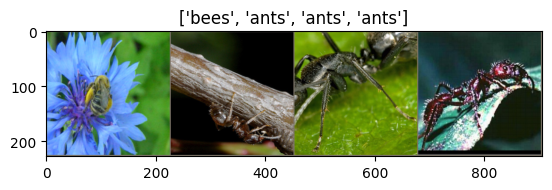

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                # epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5896 Acc: 0.7336
val Loss: 0.2176 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4996 Acc: 0.7869
val Loss: 0.1615 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3739 Acc: 0.8074
val Loss: 0.3053 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5558 Acc: 0.7951
val Loss: 0.3533 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3227 Acc: 0.8770
val Loss: 0.2790 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3917 Acc: 0.8484
val Loss: 0.2935 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5684 Acc: 0.7828
val Loss: 0.3989 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.2418 Acc: 0.8975
val Loss: 0.2596 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2836 Acc: 0.8648
val Loss: 0.2292 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3048 Acc: 0.8730
val Loss: 0.2193 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2426 Acc: 0.9016
val Loss: 0.2306 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2561 Acc: 0.8893
val Loss: 0.2001 Acc: 0.9216

Ep

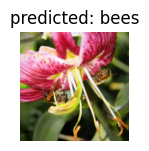

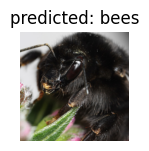

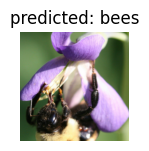

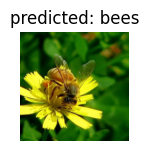

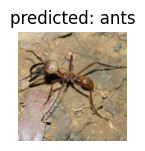

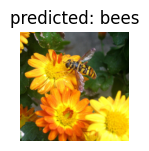

In [16]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [17]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6163 Acc: 0.6926
val Loss: 0.2609 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5872 Acc: 0.7131
val Loss: 0.3348 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5751 Acc: 0.7623
val Loss: 0.2044 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4277 Acc: 0.8156
val Loss: 0.1593 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4805 Acc: 0.7746
val Loss: 0.1916 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4111 Acc: 0.8115
val Loss: 0.1941 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.2990 Acc: 0.8893
val Loss: 0.2637 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4485 Acc: 0.7787
val Loss: 0.1892 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2364 Acc: 0.9016
val Loss: 0.1660 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3912 Acc: 0.8607
val Loss: 0.1701 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3865 Acc: 0.8607
val Loss: 0.1654 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3125 Acc: 0.8607
val Loss: 0.1789 Acc: 0.9412

Ep

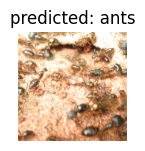

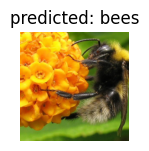

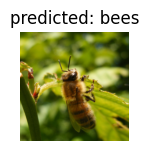

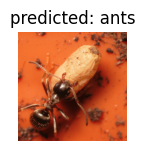

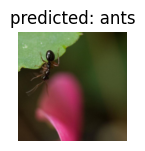

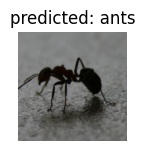

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [20]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

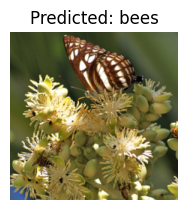

In [21]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()